In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../")

import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels import tsa
import statsmodels.graphics as sg
import sklearn


import matplotlib.pylab as plt

import seaborn as sns
sns.set_theme()

%matplotlib inline

In [2]:
df = pd.read_csv('../data/ts.csv', index_col=0, parse_dates=True)
df.shape, df.head()

((43, 11),
                   rynek  inflacja_r  inflacja_q  stopa_procentowa  \
 2014-03-31  6193.211456       100.6       100.2            0.0446   
 2014-06-30  6227.984614       100.3       100.0            0.0447   
 2014-09-30  6357.260998        99.7        99.5            0.0443   
 2014-12-31  6438.874574        99.3        99.6            0.0388   
 2015-03-31  6473.616559        98.5        99.5            0.0348   
 
             liczba_kredytow  tempo_wzrostu  ufnosc  duze_zakupy  bezrobocie  \
 2014-03-31          41942.0          104.2   -20.5        -16.3        13.5   
 2014-06-30          45499.0          104.1   -16.8        -15.0        12.0   
 2014-09-30          43653.0          103.3   -16.9        -12.7        11.5   
 2014-12-31          42993.0          103.3   -13.8        -10.7        11.4   
 2015-03-31          42169.0          104.0   -14.9        -11.5        11.5   
 
             spr_detaliczna    pkb  
 2014-03-31           105.5  103.8  
 2014-06-30

In [3]:
df.dtypes

rynek               float64
inflacja_r          float64
inflacja_q          float64
stopa_procentowa    float64
liczba_kredytow     float64
tempo_wzrostu       float64
ufnosc              float64
duze_zakupy         float64
bezrobocie          float64
spr_detaliczna      float64
pkb                 float64
dtype: object

In [4]:
columns = df.columns
columns

Index(['rynek', 'inflacja_r', 'inflacja_q', 'stopa_procentowa',
       'liczba_kredytow', 'tempo_wzrostu', 'ufnosc', 'duze_zakupy',
       'bezrobocie', 'spr_detaliczna', 'pkb'],
      dtype='object')

In [37]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = tsa.stattools.adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
adf_test(df["rynek"])

Results of Dickey-Fuller Test:
Test Statistic                  4.153091
p-value                         1.000000
#Lags Used                      5.000000
Number of Observations Used    37.000000
Critical Value (1%)            -3.620918
Critical Value (5%)            -2.943539
Critical Value (10%)           -2.610400
dtype: float64


In [38]:

def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = tsa.stattools.kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

kpss_test(df["rynek"])


Results of KPSS Test:
Test Statistic           0.910443
p-value                  0.010000
Lags Used                4.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


/tmp/ipykernel_18695/1286884801.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = tsa.stattools.kpss(timeseries, regression="c", nlags="auto")


In [22]:
decomposition_model = tsa.seasonal.seasonal_decompose(
    x=df["rynek"],
    model="additive",
    period=4
)

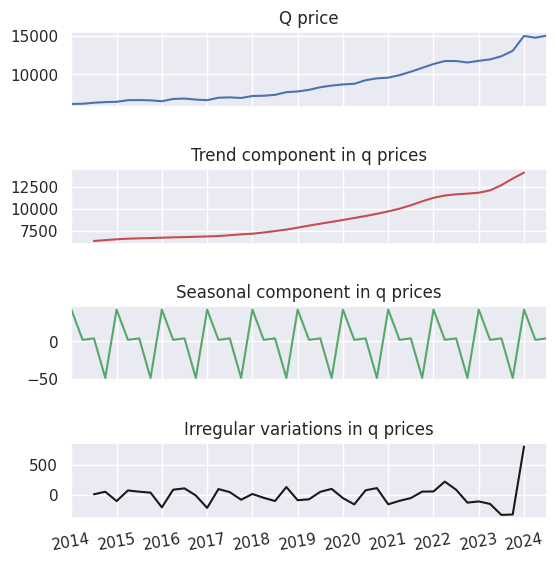

In [23]:
fig, axarr = plt.subplots(4, sharex=True)
fig.set_size_inches(5.5, 5.5)

df['rynek'].plot(ax=axarr[0], color='b', linestyle='-')
axarr[0].set_title('Q price')

pd.Series(data=decomposition_model.trend, index=df.index).plot(color='r', linestyle='-', ax=axarr[1])
axarr[1].set_title('Trend component in q prices')

pd.Series(data=decomposition_model.seasonal, index=df.index).plot(color='g', linestyle='-', ax=axarr[2])
axarr[2].set_title('Seasonal component in q prices')

pd.Series(data=decomposition_model.resid, index=df.index).plot(color='k', linestyle='-', ax=axarr[3])
axarr[3].set_title('Irregular variations in q prices')

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0)
plt.xticks(rotation=10)

plt.savefig('../images/decom_rynek.png', format='png', dpi=300)

In [31]:
adf_result = tsa.stattools.adfuller(
    decomposition_model.resid[np.where(np.isfinite(decomposition_model.resid))[0]],
    regression="c",
    autolag='AIC')
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html
adf_result

/tmp/ipykernel_18695/2304564748.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  decomposition_model.resid[np.where(np.isfinite(decomposition_model.resid))[0]],


(-4.85079663948271,
 4.343882016952795e-05,
 7,
 31,
 {'1%': -3.661428725118324,
  '5%': -2.960525341210433,
  '10%': -2.6193188033298647},
 362.099156602793)

In [32]:
multi_decomposition_model = tsa.seasonal.seasonal_decompose(
    x=df["rynek"],
    model="multiplicative",
    period=4
)

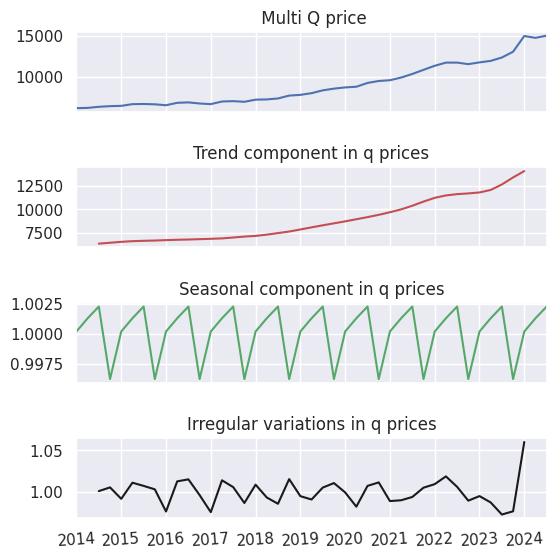

In [17]:
fig, axarr = plt.subplots(4, sharex=True)
fig.set_size_inches(5.5, 5.5)

df['rynek'].plot(ax=axarr[0], color='b', linestyle='-')
axarr[0].set_title(' Multi Q price')

pd.Series(data=multi_decomposition_model.trend, index=df.index).plot(color='r', linestyle='-', ax=axarr[1])
axarr[1].set_title('Trend component in q prices')

pd.Series(data=multi_decomposition_model.seasonal, index=df.index).plot(color='g', linestyle='-', ax=axarr[2])
axarr[2].set_title('Seasonal component in q prices')

pd.Series(data=multi_decomposition_model.resid, index=df.index).plot(color='k', linestyle='-', ax=axarr[3])
axarr[3].set_title('Irregular variations in q prices')

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0)
plt.xticks(rotation=4)

plt.savefig('../images/decom_multi_rynek.png', format='png', dpi=300)

In [34]:
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html

adf_result = tsa.stattools.adfuller(
    multi_decomposition_model.resid[
        np.where(np.isfinite(decomposition_model.resid))[0]
        ],
    regression="ctt",
    autolag='AIC')
adf_result

/tmp/ipykernel_18695/2373690441.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  multi_decomposition_model.resid[


(-4.831251378992538,
 0.001970631240467296,
 8,
 30,
 {'1%': -4.809574333333333,
  '5%': -4.0475053333333335,
  '10%': -3.6834818148148147},
 -163.91265002141978)